In [206]:
import pandas as pd
from pandas import json_normalize
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [186]:
path = "problems_2023_01_30/problems MoonBoard Masters 2019 40.json"

In [187]:
grades = ['6A+', '6B', '6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+', '8A', '8A+', '8B', '8B+']
grade_dict = {grade: i for i, grade in enumerate(grades)}

In [188]:
def get_df(path: str) -> pd.DataFrame:
    with open(path, "r") as file:
        data = pd.read_json(file)

    # Normalize the data
    main_df = json_normalize(data['data'])
    moves_df = json_normalize(data=data['data'], record_path='moves')

    # create dummy variables for the hold, i.e. description column
    move_dummies = pd.get_dummies(moves_df.description)
    moves_df = pd.concat([moves_df, move_dummies], axis=1)

    df = main_df.merge(moves_df, left_on='apiId', right_on='problemId')
    
    df = df.drop(columns=['moves', 'hasBetaVideo', 'holdsets', 'setbyId', 'userGrade', 'moonBoardConfigurationId',
                      'holdsetup.description', 'holdsetup.apiId', 'holdsetup.holdsets', 'description', 'apiId',
                      'dateUpdated', 'isMaster'])
    
    return df


In [189]:
def prepare_features(df: pd.DataFrame, min_repeats=5) -> pd.DataFrame:
    # filter out deleted problems
    df = df[df.dateDeleted.isnull()]
    # filter out problems with no grade
    df = df.query("grade != 'None'")
    df = df.assign(
        # convert grades to numeric
        grade=df.grade.map(grade_dict),
        # convert date to datetime & extract year
        year = pd.to_datetime(df.dateInserted, format='ISO8601').dt.year,
    )
    df = df.drop(columns=['dateInserted', 'dateDeleted'])
    # filter out problems with less than min_repeats repeats
    df = df.query(f"repeats >= {min_repeats}")
    
    return df

In [190]:
def group_by_problem(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) Group by all the columns that are not holds (A1 - K9)
    2) For each group (problem), sum over the holds to get dummies for each boulder
    3) Mark the start hold and the end hold by as the hold per group where isStart / isEnd is true
    """
    df.set_index('problemId', inplace=True)
    # Identify columns matching the pattern: single letter followed by 1 or 2 digits
    hold_cols = [col for col in df.columns if re.match(r'^[A-Z]\d{1,2}$', col)]

    # All other columns are non-hold columns
    non_hold_cols = [col for col in df.columns if col not in hold_cols]

    # Group by non-hold columns and sum over the hold columns
    grouped = (df
    .groupby('problemId')
    [hold_cols]
    .sum())

    # Add the non-hold columns back to the grouped DataFrame
    grouped = (df[non_hold_cols]
    .drop(columns=['isStart', 'isEnd'])
    .drop_duplicates()).merge(grouped, on='problemId')

    # find the hold_col that is true
    start_holds = df.query('isStart == True')[hold_cols].idxmax(axis=1)
    end_holds = df.query('isEnd == True')[hold_cols].idxmax(axis=1)
    start_holds.name = 'startHold'
    end_holds.name = 'endHold'

    # There can be one or two start holds, so we need to group them
    start_holds_grouped = start_holds.groupby(start_holds.index).apply(list)
    start_hold_df = pd.DataFrame(start_holds_grouped.tolist(), index=start_holds_grouped.index)
    start_hold_df.columns = ['start_hold_1', 'start_hold_2']
    start_hold_df['start_hold_2'] = start_hold_df['start_hold_2'].where(pd.notna(start_hold_df['start_hold_2']), np.nan)

    # Merge the start and end holds with the grouped DataFrame
    grouped = grouped.merge(start_hold_df, left_index=True, right_index=True).merge(end_holds, left_index=True, right_index=True)
    return grouped


In [191]:
df = get_df(path)
df = group_by_problem(df)
df = prepare_features(df)

In [192]:
df.head()

,name,grade,setby,method,userRating,repeats,isBenchmark,upgraded,downgraded,A1,...,K4,K5,K6,K7,K8,K9,start_hold_1,start_hold_2,endHold,year
problemId,,,,,,,,,,,,,,,,,,,,,
356284,11D,9,Takata,Feet follow hands,5,5,False,False,False,0,...,0,0,0,1,0,0,J3,E4,B18,2019
356298,FIGHT FOR CLIMATE,7,Simone Jungo,Feet follow hands,4,260,True,False,False,0,...,0,0,0,0,0,0,A5,NaN,E18,2019
356299,Onsight,6,Evgenya,Feet follow hands,4,14,False,False,False,0,...,0,0,0,0,0,0,C3,A5,E18,2019
356304,WOODEN IT BE NICE,7,Liting,Feet follow hands,4,392,True,False,False,0,...,0,0,0,0,0,0,D5,NaN,E18,2019
356309,THE ART OF THE MOMENT,13,flo wientjes,Feet follow hands,4,5,True,True,False,0,...,0,0,0,0,0,0,B6,C6,E18,2019


In [205]:
# vizualize the number of boulders upgraded and downgraded per setter (df.setby)
up_down_df = (df
    .groupby('setby')
    .agg({'upgraded': 'sum', 'downgraded': 'sum', 'name':'count'})
    .sort_values('name', ascending=False)
    .head(30)
)
up_down_df = (up_down_df
              [(up_down_df.upgraded > 0) | (up_down_df.downgraded > 0)] 
)
up_down_df.head(20)

,upgraded,downgraded,name
setby,,,
Kyle Knapp,8,2,307
Hoi,1,0,202
Adrian Landreth,0,1,195
Nick Wedge,1,1,170
Chalkdust66,3,0,140
Ah Hen,3,0,133
Corey Zee,1,0,107
Thomas Watts,2,1,92
KoalaClimbing,2,3,84


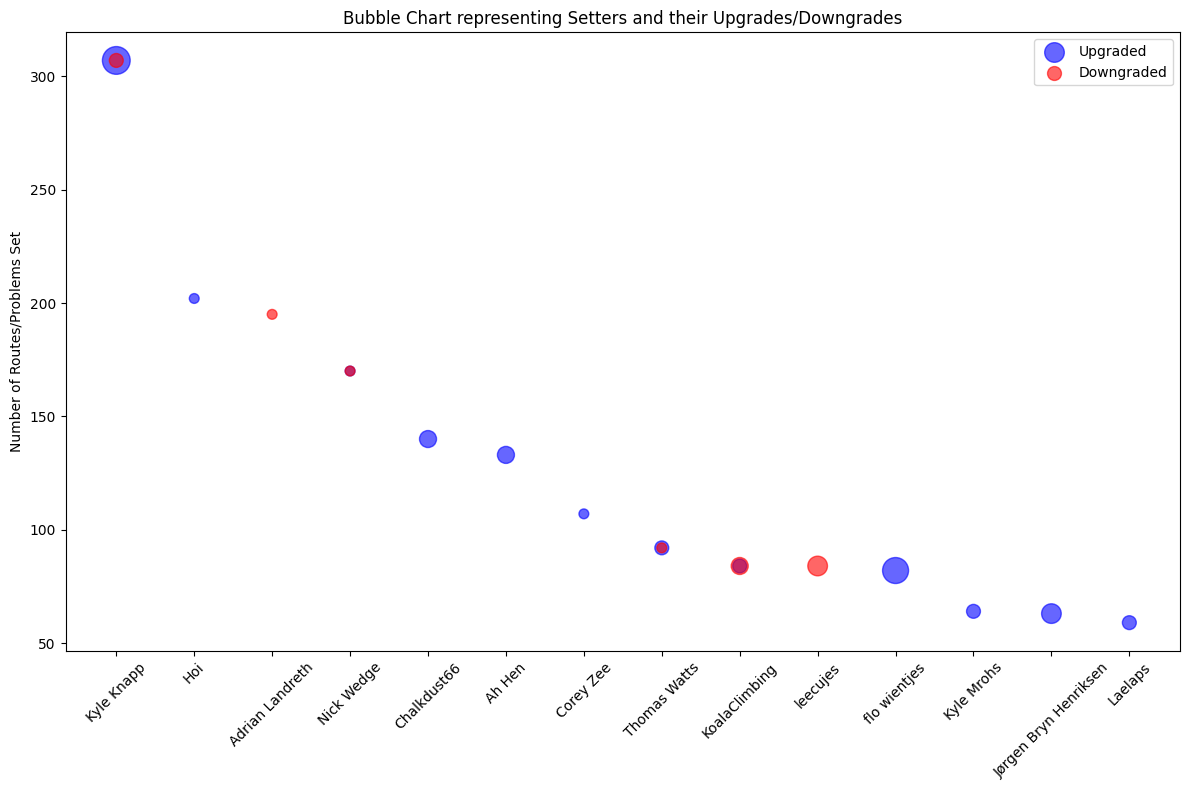

In [208]:
# Bubble chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting upgraded bubbles in blue
ax.scatter(up_down_df.index, up_down_df['name'], s=up_down_df['upgraded'] * 50, label='Upgraded', color='blue', alpha=0.6)

# Plotting downgraded bubbles in red on top of upgraded
ax.scatter(up_down_df.index, up_down_df['name'], s=up_down_df['downgraded'] * 50, label='Downgraded', color='red', alpha=0.6)

ax.set_ylabel('Number of Routes/Problems Set')
ax.set_title('Bubble Chart representing Setters and their Upgrades/Downgrades')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()